<a href="https://colab.research.google.com/github/jatin403/spotify_recommender/blob/main/sprecc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Please make sure you are viewing this in Google Colab, since github does not show interactive plotly graphs**

# **Importing the required libraries**

In [ ]:
!pip install --upgrade scikit-learn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 52.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


# **Reading the dataset**

In [ ]:
data = pd.read_csv("/content/data.csv")
year_data = pd.read_csv("/content/data_by_year.csv")
genre_data = pd.read_csv("/content/data_by_genres.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78461 entries, 0 to 78460
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valence           78461 non-null  float64
 1   year              78461 non-null  int64  
 2   acousticness      78461 non-null  float64
 3   artists           78461 non-null  object 
 4   danceability      78461 non-null  float64
 5   duration_ms       78461 non-null  int64  
 6   energy            78461 non-null  float64
 7   explicit          78461 non-null  int64  
 8   id                78461 non-null  object 
 9   instrumentalness  78461 non-null  float64
 10  key               78461 non-null  int64  
 11  liveness          78461 non-null  float64
 12  loudness          78461 non-null  float64
 13  mode              78461 non-null  int64  
 14  name              78461 non-null  object 
 15  popularity        78461 non-null  int64  
 16  release_date      78461 non-null  object

#**Data Visualisation**
Below, we are goint to look at the correlation between different features of the songs, available in the dataset, with their popularity. This gives us a visualisation of the affect each song feature has on its likeability with the general audience, depicted by its popularity.

We use the Feature Correlation visualizer below. This visualizer calculates Pearson correlation coefficients and mutual information between features and the dependent variable. This visualization can be used in feature selection to identify features with high correlation or large mutual information with the dependent variable.

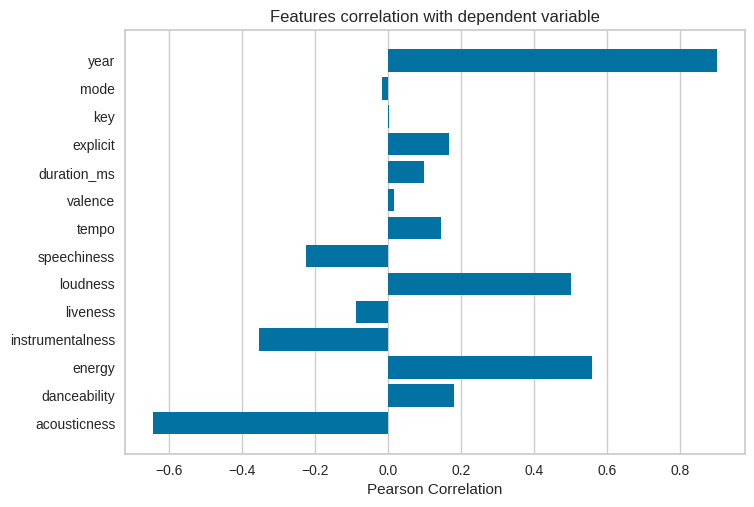

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [ ]:
from yellowbrick.target import FeatureCorrelation

fNames = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode','year']

X, y = data[fNames], data['popularity']

features = np.array(fNames)

visualizer = FeatureCorrelation(labels=features)
visualizer.fit(X, y)
visualizer.show()

Below we are grouping the dataset by decades, we will use these groups to get an idea of how music features have evolved over the years.

<Axes: xlabel='decade', ylabel='count'>

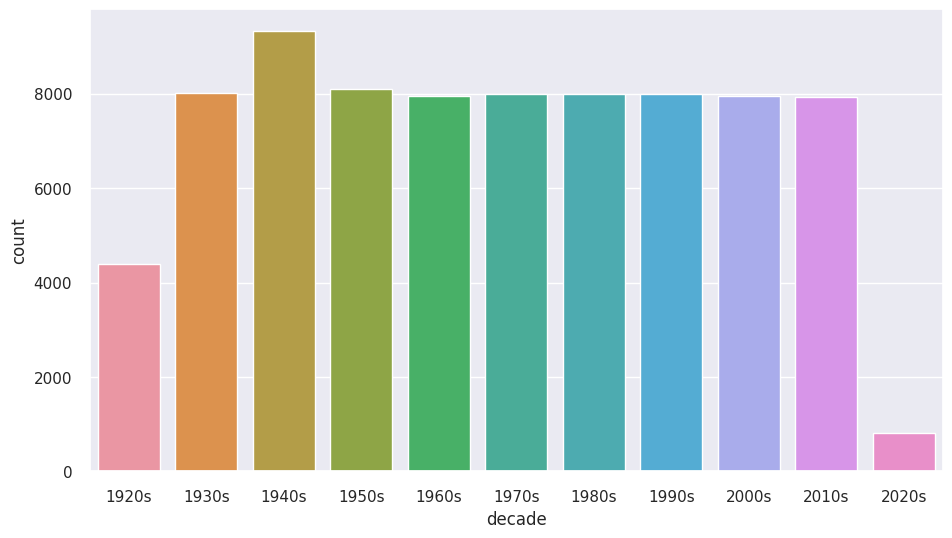

In [ ]:
def get_decade(year):
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    return decade

data['decade'] = data['year'].apply(get_decade)

# Convert the 'decade' column to a categorical type
data['decade'] = pd.Categorical(data['decade'], ordered=True)

sns.set(rc={'figure.figsize':(11, 6)})
sns.countplot(x='decade', data=data)

Below we are visualizing how selected audio features have evolved over time.

In [ ]:
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']
import plotly.express as px
fig = px.line(year_data, x='year', y=sound_features)
fig.show()

Below, we are visualising how selected audio features vary in different genres of music. We can use this to understand the unique differences in sound for the selected genres.

In [ ]:
top10_genres = genre_data.nlargest(10, 'popularity')

fig = px.bar(top10_genres, x='genres', y=['valence', 'energy', 'danceability', 'acousticness'], barmode='group')
fig.show()

#**Clustering the genres**


Below we use the KMeans clustering technique to create 20 different clusters of the dataset.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=10))])
X = genre_data.select_dtypes(np.number)
cluster_pipeline.fit(X)
genre_data['cluster'] = cluster_pipeline.predict(X)

Below we use t-SNE to transform high-dimensional data into a 2D space, scales features with a Standard Scaler, and visualizes the clustered data using Plotly Express with color-coded clusters and genre information on hover.

In [ ]:
# Visualizing the Clusters with t-SNE

from sklearn.manifold import TSNE

tsne_pipeline = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, verbose=1))])
genre_embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['genres'] = genre_data['genres']
projection['cluster'] = genre_data['cluster']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres'])
fig.show()


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2973 samples in 0.004s...
[t-SNE] Computed neighbors for 2973 samples in 0.240s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2973
[t-SNE] Computed conditional probabilities for sample 2000 / 2973
[t-SNE] Computed conditional probabilities for sample 2973 / 2973
[t-SNE] Mean sigma: 0.777516
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.102493
[t-SNE] KL divergence after 1000 iterations: 1.391938


#**Clustering the Songs**

Below we standardize numerical features, perform KMeans clustering with 20 clusters, and assign cluster labels to songs in a new 'cluster_label' column.

In [ ]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()),
                                  ('kmeans', KMeans(n_clusters=20,
                                   verbose=False))
                                 ], verbose=False)

X = data.select_dtypes(np.number)
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
data['cluster_label'] = song_cluster_labels

Below we perform PCA on the numerical features of songs, scale the features, and visualize the 2D representation of songs in a scatter plot with color-coded clusters using Plotly Express.

In [ ]:
from sklearn.decomposition import PCA

pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = data['name']
projection['cluster'] = data['cluster_label']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()

#**Creating the Recommender System**

first we install spotipy library which we'll use later to fetch the features of the inputted songs

In [ ]:
!pip install spotipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 3.0 MB/s eta 0:00:00


Below we define a function find_song that uses the Spotipy library to search for a song based on its name and release year. The function queries the Spotify API with the specified track name and year, retrieves information about the top result, including audio features, and organizes the data into a dictionary. Finally, it returns a pandas DataFrame containing the song's information.

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="2f4389bc06804538816aa571d0a27a1c", client_secret="3542d55148764f0dae0ade63da180fb2"))

def find_song(name, year):
    song_data = defaultdict()
    results = sp.search(q= 'track: {} year: {}'.format(name,year), limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = [name]
    song_data['year'] = [year]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]

    for key, value in audio_features.items():
        song_data[key] = value

    return pd.DataFrame(song_data)

The below  code offers a song recommendation system based on a list of input songs, leveraging Spotify data. The get_song_data function retrieves song details from the Spotify dataset, utilizing the find_song function for missing entries. The get_mean_vector function calculates the mean vector representation of a list of songs, handling cases where songs are not found in the dataset. The recommend_songs function computes cosine distances between the mean vector of input songs and the entire Spotify dataset, subsequently suggesting songs with the smallest distances as recommendations. The system excludes songs already present in the input list and returns metadata, including song name, year, and artists, for the recommended tracks. Note that successful execution requires the existence of the find_song function, a fitted song_cluster_pipeline, and access to the Spotify dataset.


In [ ]:
from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib

number_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']

def get_song_data(song, spotify_data):

    try:
        song_data = spotify_data[(spotify_data['name'] == song['name'])
                                & (spotify_data['year'] == song['year'])].iloc[0]
        return song_data

    except IndexError:
        return find_song(song['name'], song['year'])

def get_mean_vector(song_list, spotify_data):

    song_vectors = []

    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_data[number_cols].values
        song_vectors.append(song_vector)

    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)


def flatten_dict_list(dict_list):

    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []

    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)

    return flattened_dict


def recommend_songs( song_list, spotify_data, n_songs=10):

    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)

    song_center = get_mean_vector(song_list, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])

    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')

In [ ]:
recommend_songs([{'name': 'moon song', 'year':2020},
                {'name': 'francis forever', 'year': 2014},
                {'name': 'strawberry blond', 'year': 2013},
                {'name': 'okinawa', 'year': 2018},
                {'name': 'you wrote dont forget on your arm', 'year': 2015}],  data)

[{'name': 'White Blood', 'year': 2015, 'artists': "['Oh Wonder']"},
 {'name': 'Drifting Away', 'year': 2017, 'artists': "['khai dreams']"},
 {'name': 'i love you', 'year': 2019, 'artists': "['Billie Eilish']"},
 {'name': 'Words', 'year': 2009, 'artists': "['Gregory Alan Isakov']"},
 {'name': 'Tiger Striped Sky', 'year': 2014, 'artists': "['Roo Panes']"},
 {'name': 'my tears ricochet', 'year': 2020, 'artists': "['Taylor Swift']"},
 {'name': 'Streetcar', 'year': 2015, 'artists': "['Daniel Caesar']"},
 {'name': 'Our Town', 'year': 2006, 'artists': "['James Taylor']"},
 {'name': 'The Weary Kind', 'year': 2010, 'artists': "['Ryan Bingham']"},
 {'name': 'In a Week (feat. Karen Cowley)',
  'year': 2014,
  'artists': "['Hozier', 'Karen Cowley']"}]